In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estudio de desempleo

## Paso 1: importado de datos CSV

In [118]:
#IMPORTAR CSV
df = pd.read_csv("Data/desempleo.csv")
print('Forma del Dataframe: ',df.shape)
print('Tamaño del Dataframe: ',df.size)

Forma del Dataframe:  (203520, 23)
Tamaño del Dataframe:  4680960


In [119]:
#ESCRIBIR CABECERA (5 ROWS)
df.head(5)

,OBS_STATUS_ID,OBS_STATUS_ID.1,OBS_STATUS_ID.2,OBS_STATUS_ID.3,OBS_STATUS_ID.4,OBS_STATUS_ID.5,OBS_STATUS_ID.6,OBS_STATUS_ID.7,OBS_STATUS_ID.8,OBS_STATUS_ID.9,...,OBS_STATUS_ID.13,OBS_STATUS_ID.14,OBS_STATUS_ID.15,OBS_STATUS_ID.16,OBS_STATUS_ID.17,OBS_STATUS_ID.18,OBS_STATUS_ID.19,OBS_STATUS_NAME,OBS_CONF_ID,OBS_CONF_NAME
0,ABW,Aruba,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
1,AFE,Africa Eastern and Southern,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
2,AFG,Afghanistan,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
3,AFW,Africa Western and Central,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public
4,AGO,Angola,F,Female,Y15T24,15 to 24 years old,_T,Total,PT,Percentage,...,1960,NaN,WB_GS,Gender Statistics,0,Units,RATIO,Missing value,PU,Public


## Paso 2: Limpieza de datos

In [120]:
#EXTRAER DEL AÑO 2014 - 2019
df_2014_2019 = df[df["OBS_STATUS_ID.13"].between(2014, 2019)]

print('Forma del DataFrame:', df_2014_2019.shape)
print('Tamaño del DataFrame:', df_2014_2019.size)

Forma del DataFrame: (19080, 23)
Tamaño del DataFrame: 438840


In [121]:
# Lista simple de países europeos
europa = [
    "Spain","France","Germany","Italy","Portugal","Belgium","Netherlands","Sweden",
    "Norway","Denmark","Finland","Poland","Austria","Greece","Ireland","Czechia",
    "Slovakia","Slovenia","Hungary","Romania","Bulgaria","Croatia","Estonia",
    "Latvia","Lithuania","Luxembourg","Malta","Iceland","Switzerland","Serbia",
    "Ukraine","Russia","Turkey","Belarus","North Macedonia"
]

# Filtrar países europeos presentes en el dataset
df_europa = df_2014_2019[df_2014_2019["OBS_STATUS_ID.1"].isin(europa)]

In [122]:
df_europa = df_europa.drop(columns=[
    "OBS_STATUS_ID.2",
    "OBS_STATUS_ID.4",
    "OBS_STATUS_ID.6",
    "OBS_STATUS_ID.7",
    "OBS_STATUS_ID.8",
    "OBS_STATUS_ID.9",
    "OBS_STATUS_ID.10",
    "OBS_STATUS_ID.11",
    "OBS_STATUS_ID.12",
    "OBS_STATUS_ID.15",
    "OBS_STATUS_ID.16",
    "OBS_STATUS_ID.17",
    "OBS_STATUS_ID.18",
    "OBS_STATUS_ID.19",
    "OBS_STATUS_NAME",
    "OBS_CONF_ID",
    "OBS_CONF_NAME"
])

In [123]:
df_europa.columns = ["ID_Pais", "Pais", "Sexo", "Edad", "Año", "Desempleo"]

In [124]:
df_europa.head(10)

,ID_Pais,Pais,Sexo,Edad,Año,Desempleo
171734,AUT,Austria,Female,15 to 24 years old,2014,10082.0
171737,BEL,Belgium,Female,15 to 24 years old,2014,22335.0
171741,BGR,Bulgaria,Female,15 to 24 years old,2014,23741.0
171745,BLR,Belarus,Female,15 to 24 years old,2014,NaN
171757,CHE,Switzerland,Female,15 to 24 years old,2014,8562.0
171774,CZE,Czechia,Female,15 to 24 years old,2014,17102.0
171775,DEU,Germany,Female,15 to 24 years old,2014,7052.0
171778,DNK,Denmark,Female,15 to 24 years old,2014,12858.0
171790,ESP,Spain,Female,15 to 24 years old,2014,52933.0
171791,EST,Estonia,Female,15 to 24 years old,2014,10021.0


In [125]:
print(df_europa.columns.tolist())

['ID_Pais', 'Pais', 'Sexo', 'Edad', 'Año', 'Desempleo']


In [126]:
#Paises en español
paises_es = {
    "Austria": "Austria",
    "Belgium": "Bélgica",
    "Bulgaria": "Bulgaria",
    "Belarus": "Bielorrusia",
    "Switzerland": "Suiza",
    "Germany": "Alemania",
    "France": "Francia",
    "Italy": "Italia",
    "Spain": "España",
    "Portugal": "Portugal",
    "Netherlands": "Países Bajos",
    "Greece": "Grecia",
    "Poland": "Polonia",
    "Sweden": "Suecia",
    "Norway": "Noruega",
    "Finland": "Finlandia",
    "Denmark": "Dinamarca",
    "Ireland": "Irlanda",
    "United Kingdom": "Reino Unido",
    "Czech Republic": "República Checa",
    "Slovakia": "Eslovaquia",
    "Slovenia": "Eslovenia",
    "Croatia": "Croacia",
    "Czechia": "República Checa",
    "Hungary": "Hungría",
    "Romania": "Rumanía",
    "Estonia": "Estonia",
    "Latvia": "Letonia",
    "Lithuania": "Lituania",
    "Luxembourg": "Luxemburgo",
    "Malta": "Malta",
    "Cyprus": "Chipre",
    "Iceland": "Islandia",
    "Serbia": "Serbia",
    "Montenegro": "Montenegro",
    "North Macedonia": "Macedonia del Norte",
    "Albania": "Albania",
    "Bosnia and Herzegovina": "Bosnia y Herzegovina",
    "Ukraine": "Ucrania",
    "Moldova": "Moldavia",
    "Russia": "Rusia",
    "Turkey": "Turquía"
}

df_europa['Pais'] = df_europa['Pais'].map(paises_es).fillna(df_europa['Pais'])


In [127]:
df_europa.head(10)

,ID_Pais,Pais,Sexo,Edad,Año,Desempleo
171734,AUT,Austria,Female,15 to 24 years old,2014,10082.0
171737,BEL,Bélgica,Female,15 to 24 years old,2014,22335.0
171741,BGR,Bulgaria,Female,15 to 24 years old,2014,23741.0
171745,BLR,Bielorrusia,Female,15 to 24 years old,2014,NaN
171757,CHE,Suiza,Female,15 to 24 years old,2014,8562.0
171774,CZE,República Checa,Female,15 to 24 years old,2014,17102.0
171775,DEU,Alemania,Female,15 to 24 years old,2014,7052.0
171778,DNK,Dinamarca,Female,15 to 24 years old,2014,12858.0
171790,ESP,España,Female,15 to 24 years old,2014,52933.0
171791,EST,Estonia,Female,15 to 24 years old,2014,10021.0


## Paso 3: análisis

In [128]:
# Agrupamos por País y Sexo (suma de todos los años 2014-2019)
df_sex_country = df_europa.groupby(["Pais", "Sexo"])["Desempleo"].sum().reset_index()

# Pivotamos para tener el Sexo como columnas
df_sex_pivot = df_sex_country.pivot(index="Pais", columns="Sexo", values="Desempleo").fillna(0)

# Calculamos columnas adicionales
df_sex_pivot["Total"] = df_sex_pivot["Female"] + df_sex_pivot["Male"]
df_sex_pivot["Brecha (F - M)"] = df_sex_pivot["Female"] - df_sex_pivot["Male"]

# Ordenamos por Total descendente
df_sex_pivot.sort_values(by="Total", ascending=False, inplace=True)

print("===== DESEMPLEO TOTAL (15-24 años) POR PAÍS Y SEXO (2014-2019) =====")
print(df_sex_pivot.head())
print("\n")

# Identificar país con mayor y menor desempleo
max_total_country = df_sex_pivot["Total"].idxmax()
min_total_country = df_sex_pivot["Total"].idxmin()

print(df_sex_country.describe())

print(f"País con Mayor Desempleo Total: {max_total_country} → {df_sex_pivot.loc[max_total_country, 'Total']:.0f}")
print(f"País con Menor Desempleo Total: {min_total_country} → {df_sex_pivot.loc[min_total_country, 'Total']:.0f}")

===== DESEMPLEO TOTAL (15-24 años) POR PAÍS Y SEXO (2014-2019) =====
Sexo                    Female       Male       Total  Brecha (F - M)
Pais                                                                 
Macedonia del Norte  780513.36  818059.61  1598572.97       -37546.25
Grecia               907031.00  634835.44  1541866.44       272195.56
España               644474.36  624204.33  1268678.69        20270.03
Serbia               646979.70  475552.09  1122531.79       171427.61
Italia               527464.23  531054.89  1058519.12        -3590.66


           Desempleo
count      96.000000
mean   282928.961354
std    172578.684906
min     92525.130000
25%    169107.840000
50%    231578.230000
75%    322593.715000
max    907031.000000
País con Mayor Desempleo Total: Macedonia del Norte → 1598573
País con Menor Desempleo Total: Alemania → 227200


## Paso 4: comunicación de datos y visualización

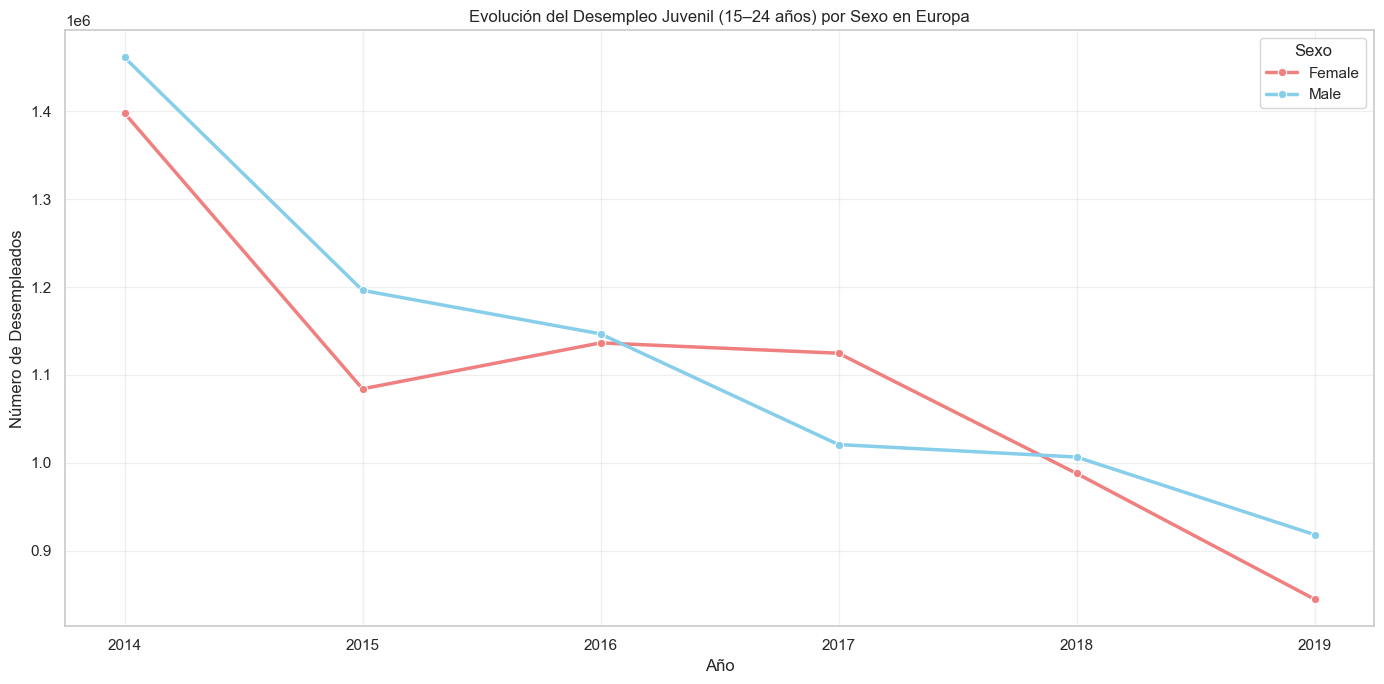

In [129]:
df_jovenes = df_europa[
    (df_europa["Edad"] == "15 to 24 years old") &
    (df_europa["Sexo"].isin(["Female", "Male"]))
]

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_jovenes,
    x="Año",
    y="Desempleo",
    hue="Sexo",
    estimator="sum",
    errorbar=None,
    linewidth=2.5,
    palette={"Female": "lightcoral", "Male": "skyblue"},
    marker="o"
)

plt.title("Evolución del Desempleo Juvenil (15–24 años) por Sexo en Europa")
plt.xlabel("Año")
plt.ylabel("Número de Desempleados")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Mostramos gráficos de Desempleo Femenino vs. Masculino

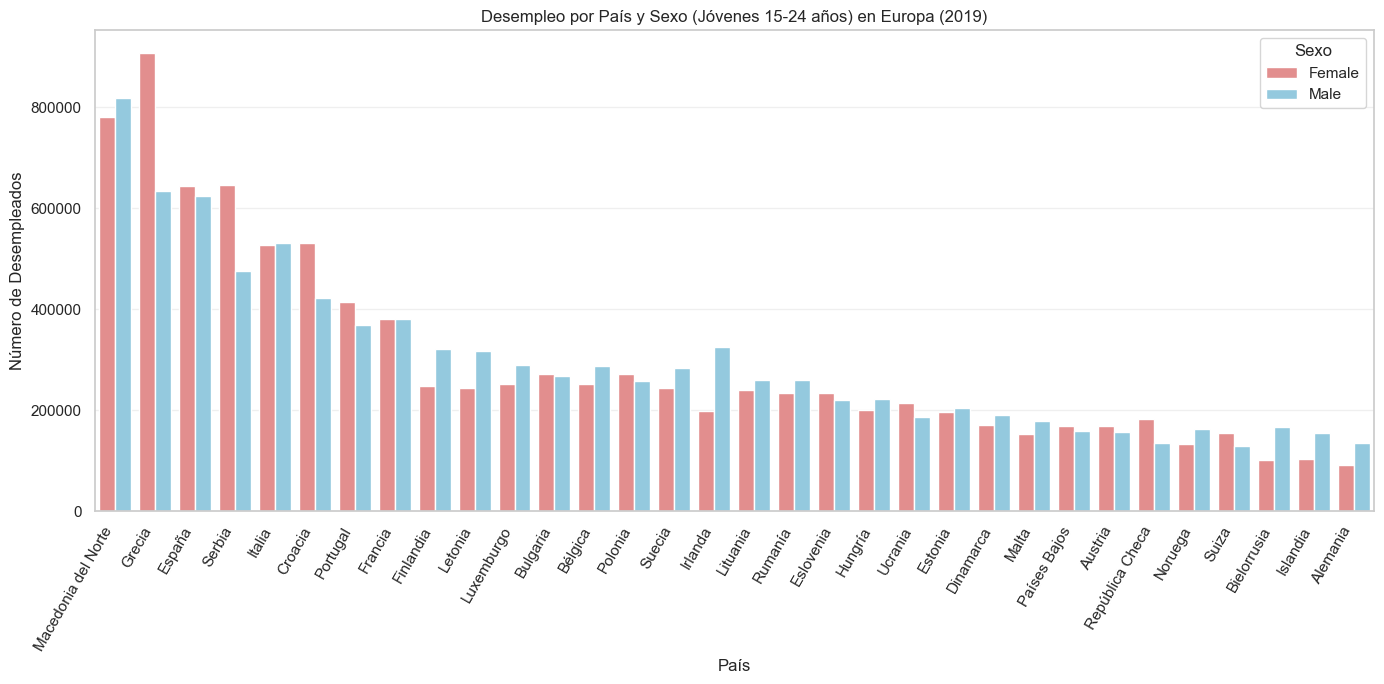

In [130]:
# Convertir a formato largo (long format) para Seaborn
df_long = df_sex_pivot.reset_index().melt(
    id_vars=df_sex_pivot.index.name, 
    value_vars=["Female", "Male"],
    var_name="Sexo",
    value_name="Desempleo"
)

plt.figure(figsize=(14, 7))

# Gráfico de barras apiladas con Seaborn
sns.barplot(
    data=df_long,
    x=df_sex_pivot.index.name,
    y="Desempleo",
    hue="Sexo",
    palette={"Female": "lightcoral", "Male": "skyblue"},
    estimator=sum,
)

# Ajustar para que sea apilado
# Seaborn no soporta stacking nativamente, así que sumamos manualmente:
# Recalcula posiciones desde el barplot dibujado
ax = plt.gca()
for c in ax.containers:
    # valores de cada categoría
    labels = [v.get_height() for v in c]
    # Mostrar valores si quieres: ax.bar_label(c, label_type="center")

# Título y etiquetas
plt.title("Desempleo por País y Sexo (Jóvenes 15-24 años) en Europa (2019)")
plt.ylabel("Número de Desempleados")
plt.xlabel("País")
plt.xticks(rotation=60, ha='right')
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


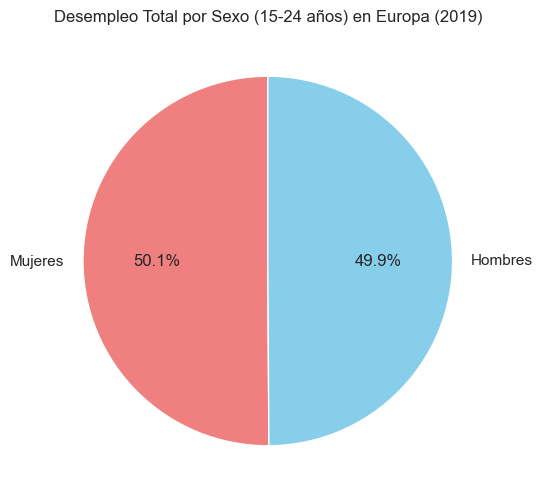

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# Activar estilo de Seaborn
sns.set_theme(style="whitegrid")

# Totales por sexo
totales = df_sex_pivot[["Female", "Male"]].sum()

plt.figure(figsize=(6, 6))
plt.pie(
    totales,
    labels=["Mujeres", "Hombres"],
    autopct='%1.1f%%',
    colors=["lightcoral", "skyblue"],
    startangle=90
)

plt.title("Desempleo Total por Sexo (15-24 años) en Europa (2019)")
plt.show()


## Paso extra: preparación de datos para uso de compañeros

### Aquí escribo un resumen de los dataframes y series utilizados en limpio para facilitar la extracción de los mismos por parte de mis compañeros

In [132]:
# 1. RECONSTRUIR df_sex_pivot con todas las columnas
# (Esta línea soluciona el KeyError, ya que añade de nuevo la columna "Brecha (F - M)")
df_sex_pivot = df_europa.groupby(["Pais", "Sexo"])["Desempleo"].sum().unstack(fill_value=0)
df_sex_pivot["Total"] = df_sex_pivot["Female"] + df_sex_pivot["Male"]
df_sex_pivot["Brecha (F - M)"] = df_sex_pivot["Female"] - df_sex_pivot["Male"]
df_sex_pivot.sort_values(by="Total", ascending=False, inplace=True) # Reordenar por el total

# 2. DATAFRAMES EXTRAIDOS
df_final_europa = df_europa.copy()
df_desempleo_sexo_pais = df_sex_pivot[["Female", "Male", "Total", "Brecha (F - M)"]].copy()

# -----------------------------------------------------------------------

print('RESUMEN DE DATAFRAMES EXTRAIDOS:')
print("-" * 50)

print("1. DATAFRAME LIMPIO (Europa, 2019, 15-24):")
print(df_final_europa.head())
print("_" * 50)

print("2. DESEMPLEO JUVENIL POR SEXO Y PAÍS (con Brecha F-M):")
print(df_desempleo_sexo_pais.head())
print("_" * 50)

# Guardar los DataFrames finales en CSV
df_final_europa.to_csv("df_final_europa_desempleo.csv", index=False)
df_desempleo_sexo_pais.to_csv("df_desempleo_sexo_pais_resumen.csv", index=True)

print("\n")
print("DataFrames guardados como CSV:")
print("- df_final_europa_desempleo.csv")
print("- df_desempleo_sexo_pais_resumen.csv")

RESUMEN DE DATAFRAMES EXTRAIDOS:
--------------------------------------------------
1. DATAFRAME LIMPIO (Europa, 2019, 15-24):
       ID_Pais         Pais    Sexo                Edad   Año  Desempleo
171734     AUT      Austria  Female  15 to 24 years old  2014    10082.0
171737     BEL      Bélgica  Female  15 to 24 years old  2014    22335.0
171741     BGR     Bulgaria  Female  15 to 24 years old  2014    23741.0
171745     BLR  Bielorrusia  Female  15 to 24 years old  2014        NaN
171757     CHE        Suiza  Female  15 to 24 years old  2014     8562.0
__________________________________________________
2. DESEMPLEO JUVENIL POR SEXO Y PAÍS (con Brecha F-M):
Sexo                    Female       Male       Total  Brecha (F - M)
Pais                                                                 
Macedonia del Norte  780513.36  818059.61  1598572.97       -37546.25
Grecia               907031.00  634835.44  1541866.44       272195.56
España               644474.36  624204.33  126867